<a href="https://colab.research.google.com/github/jeremychia/singapore-parliament-speeches/blob/main/Singapore_Parliament_Speeches_4G_PM_Candidate_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

1. **Installing BigQuery Client Library**: To interact with BigQuery in Google Colab, you need to install the BigQuery client library.

2. **Authenticating to GCP**: To authenticate to Google Cloud Platform (GCP) and access BigQuery resources, you need to authenticate your session. Please make sure you have access to the `singapore-parliament-speeches` project on GCP. If you do not have access, please reach out to jeremyjchia@gmail.com.

3. **Creating a BigQuery Client**: Create a BigQuery client to interact with BigQuery datasets and tables.

In [1]:
# install bigquery client library
!pip install google-cloud-bigquery --quiet

In [2]:
# authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [3]:
# set up project id
project_id = "singapore-parliament-speeches"

In [4]:
# create a bigquery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

# Functions

## Extracting Data

This consists of the following functions, which are called later on. This happens sequentially.

1. `query_by_member_name`: give this function a name of a parliament member, and it gives you a SQL query that finds all speeches made by that member, arranged with the newest speeches first.

2. `get_speech_df_from_query`: give it a query, and it gives you back the results in a table format.

3. `combine_text_by_topic`: takes a table where each row represents a speech and combines speeches with the same topic into one row, making it easier to analyse and work with.



In [5]:
# run query
import pandas as pd

def get_speech_df_from_query(query):

  query_job = client.query(query)
  df = query_job.to_dataframe()

  return df

In [6]:
# compbine text by topic
def combine_text_by_topic(df):
    combined_text = {}
    for index, row in df.iterrows():
        topic_id = row['topic_id']
        text = row['speech_text']
        if topic_id not in combined_text:
            combined_text[topic_id] = {'date': row['date'], 'topic_title': row['topic_title'], 'speech_text': ""}
        combined_text[topic_id]['speech_text'] += ' ' + text

    result_df = pd.DataFrame.from_dict(combined_text, orient='index')
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'topic_id'}, inplace=True)

    return result_df


## Preprocessing

In textual pre-processing, the following can be done:

|Function|Description|
|-|-|
|`lowercase_text`|Converts the input text to lowercase.|
|`remove_punctuation`|Removes punctuation from the input text.|
|`remove_stopwords`|Removes stopwords from the input text.|
|`lemmatize_text`|Lemmatizes the input text, reducing words to their base or dictionary form.|
||*(lemmatisation is not done in this analysis)*|
|`clean_text`|Performs general cleaning on the input text, removing non-ASCII characters,|
||numbers, extra spaces, newlines, tabs, carriage returns, and form feeds.|

In addition, there additional stopwords which are removed:

|Category|Stopwords|
|-|-|
|Personal Titles and References|mr, deputy, speaker, prime minister, assoc prof, please, refer, mentioned|
|Location|singapore|
|Time and Numerals|year, new, time, last, may, many, earlier, first, one|
|Continuation and Verb Forms|continue, would, take, put|
|Pronouns and Possession|member, us, ministry, u, not, like, can, well|


In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# text preprocessing functions
def lowercase_text(text):
  return text.lower()

def remove_punctuation(text):
  punctuation = string.punctuation
  return "".join([char for char in text if char not in punctuation])

def remove_stopwords(text, custom_stopwords=[]):
  stopword_list = stopwords.words('english')
  stopword_list.extend(custom_stopwords)

  words = [word for word in text.split() if word not in stopword_list]
  return " ".join(words)

def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word) for word in text.split()]
  return " ".join(words)

def clean_text(text):
  cleaned_text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
  cleaned_text = re.sub(r"\d+", "", cleaned_text)  # Remove numbers
  cleaned_text = re.sub(r"\s+", " ", cleaned_text)  # Replace multiple spaces with a single space
  cleaned_text = re.sub(r"\n|\t|\r|\f", "", cleaned_text)  # Remove newlines, tabs, carriage returns, and form feeds
  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
def preprocess_text(df):

  custom_stopwords = ['mr', 'also', 'singapore', 'year', 'new',
                    'singaporean', 'continue', 'would', 'time', 'member', 'may',
                    'last', 'can', 'not', 'like', 'put', 'place', 'u', 'take',
                    'many', 'deputy', 'speaker', 'please', 'refer', 'prime',
                    'minister', 'mentioned', 'earlier', 'one', 'us', 'first',
                    'members', 'well', 'assoc', 'prof', 'ministry', 'july']

  df['speech_text'] = df['speech_text'].apply(lowercase_text)
  df['speech_text'] = df['speech_text'].apply(remove_punctuation)
  df['speech_text'] = df['speech_text'].apply(remove_stopwords, custom_stopwords=custom_stopwords)
  #df['speech_text'] = df['speech_text'].apply(lemmatize_text)
  df['speech_text'] = df['speech_text'].apply(clean_text)

  return df

## N-Grams

1. `get_top_n_words`: concatenates text from a specified column, counts the frequency of each word, and returns the top words with frequencies above a specified minimum frequency threshold.
2. `get_top_n_bigrams`: Bigrams specifically refer to n-grams of size 2, meaning they consist of pairs of consecutive words in a text. They capture the relationships between adjacent words and are commonly used in tasks such as text mining, sentiment analysis, and part-of-speech tagging. Bigrams provide valuable insights into the co-occurrence patterns of words and can help identify phrases or expressions that frequently appear together in a given corpus of text.

In [9]:
from collections import Counter

def get_top_n_words(text_column, min_freq=5):
    # Concatenate all text from the text column
    all_text = " ".join(text_column.tolist())

    # Count the frequency of each word
    word_counts = Counter(all_text.split())

    # Filter words with frequency >= min_freq
    top_n_words = [(word, count) for word, count in word_counts.items() if count >= min_freq]

    return top_n_words

# print(f"Top {top_n} words and their counts:")
# for word, count in top_n_words:
#   print(f"{word}: {count}")

In [10]:
from nltk import word_tokenize
nltk.download('punkt')

def get_top_n_bigrams(text_column, min_freq=5):
    # Combine all text from the column
    all_text = " ".join(text_column.tolist())

    # Tokenize text into words
    words = word_tokenize(all_text)

    # Generate bi-grams (pairs of consecutive words)
    bigrams = zip(words[:-1], words[1:])

    # Count bi-gram occurrences
    bigram_counts = Counter(bigrams)

    # Filter bigrams with frequency >= min_freq
    top_n_bigrams = [(bigram, count) for bigram, count in bigram_counts.items() if count >= min_freq]

    return top_n_bigrams

# print(f"Top {top_n} bi-grams and their counts:")
# for bigram, count in top_n_bigrams:
#   print(f"{bigram[0]} {bigram[1]}: {count}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
def top_n_list_to_df(top_n_list, member_name, type='word'):
    df = pd.DataFrame(top_n_list, columns=[f'{type}', 'count'])
    df['member_name'] = member_name

    if type == 'bigram':
        df[type] = df[type].apply(lambda x: ' '.join(x))

    elif type != 'word':
        print('Type not recognized - options: (\'word\', \'bigram\')')
        return None

    return df

## Readaibility

The readability (Flesch reading ease) of the text is defined by:

$FRES = 206.835 - 1.015\left(\frac{\text{total words}}{\text{total sentences}}\right) - 84.6\left(\frac{\text{total syllables}}{\text{total words}}\right)$

There are some functions needed here to help with this.

* `calc_number_of_words`: gives the number of words based on the text given.
* `calc_number_of_sentences`: gives the number of sentences based on the text given.
* `calc_number_of_syllables`: gives the number of syllables based on the text given.

In [12]:
def calc_number_of_words(text):
    # Split text into words
    words = text.split()
    return len(words)

In [13]:
def calc_number_of_sentences(text):
    # Split text into sentences
    sentences = re.split(r'[.!?]+', text)
    # Remove empty strings (e.g., caused by trailing punctuation)
    sentences = [sentence for sentence in sentences if sentence]
    return len(sentences)

In [14]:
import nltk
from nltk.corpus import cmudict

nltk.download('cmudict')
pronouncing_dict = cmudict.dict()

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


In [15]:
def count_syllables(word):
    """Count the number of syllables in a word."""
    if word.lower() in pronouncing_dict:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in pronouncing_dict[word.lower()]])
    else:
        # If the word is not found in the dictionary, use the provided heuristic
        return calc_number_of_syllables_alt(word)

def calc_number_of_syllables_alt(word):
    # Define vowels
    vowels = 'aeiouy'
    # Convert word to lowercase
    word = word.lower()
    # Initialize syllable count
    count = 0
    # Initialize flag to track if previous character was a vowel
    prev_char_was_vowel = False

    # Iterate through each character in the word
    for char in word:
        # Check if the character is a vowel
        if char in vowels:
            # Check if the previous character was not a vowel
            if not prev_char_was_vowel:
                # Increment syllable count for a new vowel sequence
                count += 1
            # Update the flag
            prev_char_was_vowel = True
        else:
            # Update the flag if the character is not a vowel
            prev_char_was_vowel = False

    # Adjust syllable count for specific cases
    if word.endswith(('e', 'es', 'ed')) and not word.endswith(('le', 'ble', 'ple')):
        count -= 1
    # Ensure at least one syllable for any word
    if count == 0:
        count = 1

    # Return the calculated syllable count
    return count

In [16]:
def calc_number_of_syllables(text):
    """Calculate the number of syllables in a given text."""
    words = nltk.word_tokenize(text)
    syllable_counts = [count_syllables(word) for word in words]
    return sum(syllable_counts)

In [17]:
def calc_fres(row):
    return 206.835 - 1.015 * (row['n_words'] / row['n_sentences']) - 84.6 * (row['n_syllables'] / row['n_words'])

# Analysis

Who are the 4G Ministers? Lawrence Wong was chosen from amongst the pack to be the 'first amongst equals' to be the leader of his party, and the next annointed Prime Minister.

This analysis focuses specifically on the three names singled out _(Source: [Nikkei Asia](https://asia.nikkei.com/Politics/Singapore-searches-for-next-prime-minister-3-names-to-know), [TODAYOnline](https://www.todayonline.com/singapore/3-months-after-future-pm-thrown-question-heres-where-contenders-stand),2021)_ on the run-up to the [selection of the next party leader](https://www.todayonline.com/singapore/15-out-19-leaders-consulted-chose-lawrence-wong-top-pick-succeed-pm-no-close-second-khaw-boon-wan-1874621):

1. Chan Chun Sing
2. Lawrence Wong
3. Ong Ye Kung



## Participation

* What is the attendance rate?
* How many of those sittings did they speak in?
* How many topics within those sittings did they sit in?

How does this compare against the others?

### What is the attendance rate?

In [18]:
members_to_analyse = ['Lawrence Wong', 'Ong Ye Kung', 'Chan Chun Sing']
formatted_members = ', '.join([f"'{member}'" for member in members_to_analyse])

In [19]:
query_attendance = f"""
select
    member_name,
    count_sittings_present,
    count_sittings_total,
    round(
        safe_divide(count_sittings_present, count_sittings_total) * 100, 2
    ) as percentage_attendance
from `singapore-parliament-speeches.prod_dim.dim_members`
where member_name in ({formatted_members})
"""

In [20]:
attendance = get_speech_df_from_query(query_attendance)

In [21]:
attendance.head()

,member_name,count_sittings_present,count_sittings_total,percentage_attendance
0,Ong Ye Kung,253,269,94.05
1,Chan Chun Sing,355,358,99.16
2,Lawrence Wong,355,358,99.16


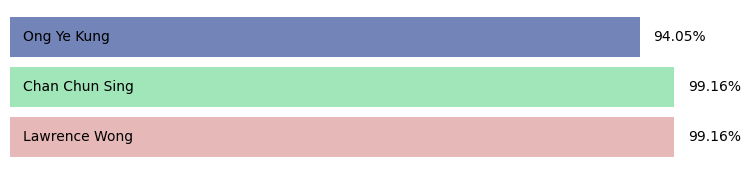

In [23]:
import matplotlib.pyplot as plt
# Define members and their assigned Pantone colors
members_colors = {
    'Ong Ye Kung': '#7284B8',  # Darker shade of Serenity
    'Chan Chun Sing': '#A0E6B8',  # Lighter shade of Pale Green
    'Lawrence Wong': '#E6B8B7'  # Darker shade of Misty Rose
}

# Create horizontal bar plot
plt.figure(figsize=(9, 2))
bars = plt.barh(attendance['member_name'], attendance['percentage_attendance'], color=[members_colors[m] for m in attendance['member_name']])

# Add percentage labels to bars
for bar, name, percentage in zip(bars, attendance['member_name'], attendance['percentage_attendance']):
    plt.text(bar.get_width()+2, bar.get_y() + bar.get_height()/2, f'{percentage}%',
             va='center', ha='left', fontsize=10, color='black', fontname='DejaVu Sans')
    plt.text(2, bar.get_y() + bar.get_height()/2, name, va='center', ha='left', fontsize=10, color='black', fontname='DejaVu Sans')

# Remove axes and borders
plt.axis('off')

# Show the plot
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

In [24]:
query_absent_dates = f"""
select date, member_name
from `singapore-parliament-speeches.prod_fact.fact_attendance`
where
    member_name in ({formatted_members})
    and is_present = false
order by member_name, date
"""

In [25]:
absent_dates = get_speech_df_from_query(query_absent_dates)

In [26]:
absent_dates['date'] = absent_dates['date'].apply(lambda x: pd.to_datetime(x).strftime("%d %b %Y"))

In [27]:
absent_dates.head(10)
# note, there are still some more dates

,date,member_name
0,11 Jul 2018,Chan Chun Sing
1,04 Nov 2019,Chan Chun Sing
2,05 Nov 2019,Chan Chun Sing
3,02 Oct 2017,Lawrence Wong
4,03 Oct 2017,Lawrence Wong
5,01 Nov 2021,Lawrence Wong
6,14 Apr 2016,Ong Ye Kung
7,10 Oct 2016,Ong Ye Kung
8,06 Nov 2017,Ong Ye Kung
9,05 Feb 2018,Ong Ye Kung


In [28]:
# Convert 'Date' column to 'Year'
absent_dates['date'] = pd.to_datetime(absent_dates['date'])
absent_dates['year'] = absent_dates['date'].dt.year

# Group by 'Member' and 'Year', count number of absences
absences_per_year = absent_dates.groupby(['year', 'member_name']).size().unstack(fill_value=0)

In [29]:
absences_per_year

member_name,Chan Chun Sing,Lawrence Wong,Ong Ye Kung
year,,,
2016,0,0,2
2017,0,2,1
2018,1,0,1
2019,2,0,2
2020,0,0,3
2021,0,1,2
2022,0,0,1
2023,0,0,4


In [30]:
query_average_absence_by_party = """
with
    by_date as (
        select
            date,
            member_party,
            countif(is_present) as count_present,
            count(date) as count_total_sittings,
            count(distinct member_name) as count_members
        from `singapore-parliament-speeches.prod_mart.mart_attendance`
        where member_party is not null
        group by all
    ),

    by_year as (
        select
            extract(year from date) as year,
            member_party,
            sum(count_present) as count_present,
            sum(count_total_sittings) as count_total_sittings,
            avg(count_members) as avg_count_members
        from by_date
        group by all
    )

select
    year,
    member_party,
    count_present,
    count_total_sittings,
    round(avg_count_members, 1) as avg_count_members,
    round((count_total_sittings - count_present) / avg_count_members, 2) as avg_absences
from by_year
where member_party = 'PAP'
and year between 2016 and 2024
order by 1, 2
"""

In [31]:
average_absence_by_year_pap = get_speech_df_from_query(query_average_absence_by_party)

In [32]:
average_absence_by_year_pap

,year,member_party,count_present,count_total_sittings,avg_count_members,avg_absences
0,2016,PAP,2237,2396,82.6,1.92
1,2017,PAP,1901,2070,82.8,2.04
2,2018,PAP,2472,2624,82.0,1.85
3,2019,PAP,2121,2296,82.0,2.13
4,2020,PAP,2705,2801,82.4,1.17
5,2021,PAP,2414,2490,83.0,0.92
6,2022,PAP,2696,2905,83.0,2.52
7,2023,PAP,2922,3210,82.3,3.50
8,2024,PAP,1427,1503,79.1,0.96


In [33]:
average_absence_by_year_pap = average_absence_by_year_pap.set_index('year')['avg_absences']

In [34]:
result = absences_per_year.join(average_absence_by_year_pap, how='outer').fillna(0)

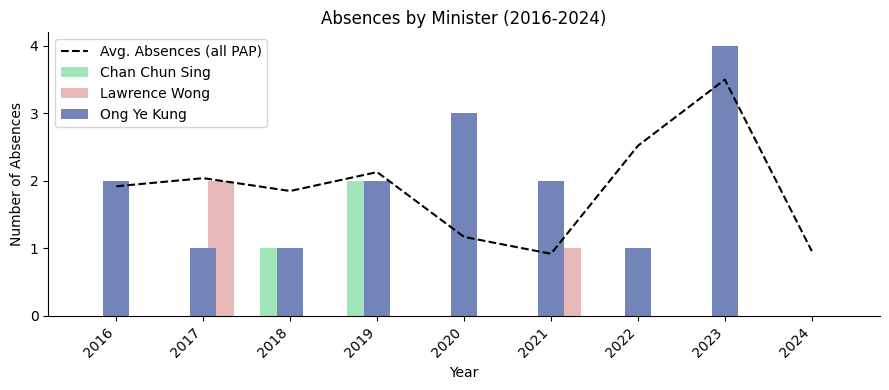

In [35]:
from matplotlib.ticker import MaxNLocator

years = result.index  # Extract years as labels

# Create the bar chart
fig, ax2 = plt.subplots(figsize=(9, 4))
width = 0.3  # Width of each bar

# Plot bars for each person
bar1 = ax2.bar(years - width + 0.1, result['Chan Chun Sing'], width, label='Chan Chun Sing', color=members_colors['Chan Chun Sing'])
bar2 = ax2.bar(years + width - 0.1, result['Lawrence Wong'], width, label='Lawrence Wong', color=members_colors['Lawrence Wong'])
bar3 = ax2.bar(years, result['Ong Ye Kung'], width, label='Ong Ye Kung', color=members_colors['Ong Ye Kung'])

# Plot the dotted line for average absences
ax2.plot(years, result['avg_absences'], linestyle='--', color='black', label='Avg. Absences (all PAP)')

# Set labels and title
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Absences')
ax2.set_title('Absences by Minister (2016-2024)')
plt.xticks(rotation=45, ha='right', fontsize=10, fontname='DejaVu Sans')
plt.yticks(fontsize=10, fontname='DejaVu Sans')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(top=False, right=False)  # Remove top and right ticks
ax2.spines['top'].set_visible(False)  # Remove top spine
ax2.spines['right'].set_visible(False)  # Remove right spine

# Add legend
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Sittings and Topics

* How many of those sittings did they speak in?
* How many topics within those sittings did they sit in?

In [36]:
query_count_sittings_topics = f"""
with
    sittings as (
        select date from `singapore-parliament-speeches.prod_fact.fact_sittings`
    ),

    members as (
        select member_name
        from `singapore-parliament-speeches.prod_dim.dim_members`
        where member_name in ({formatted_members})
    ),

    cross_join as (select * from sittings cross join members),

    speeches as (
        select date, topic_id, member_name, speech_text
        from `singapore-parliament-speeches.prod_mart.mart_speeches`
        where member_name in ({formatted_members})
    ),

    by_date as (
        select date, member_name, count(distinct topic_id) as count_topics
        from speeches
        group by all
    ),

    populate_info as (
        select
            cross_join.date,
            cross_join.member_name,
            coalesce(by_date.count_topics, 0) as count_topics,
            attendance.is_present as is_attendance,
        from cross_join
        left join
            by_date
            on cross_join.date = by_date.date
            and cross_join.member_name = by_date.member_name
        left join
            `singapore-parliament-speeches.prod_fact.fact_attendance` as attendance
            on cross_join.date = attendance.date
            and cross_join.member_name = attendance.member_name

    ),

    info_by_date as (
        select
            extract(year from `date`) as year,
            member_name,
            sum(count_topics) as count_topics,
            countif(count_topics > 0) as count_sittings_spoken,
            countif(is_attendance = true) as count_sittings_present,
            countif(is_attendance is not null) as count_sittings_total,
        from populate_info
        group by all
    )

select
  year,
  member_name,
  count_topics,
  count_sittings_spoken,
  count_sittings_present,
  count_sittings_total
from info_by_date
order by year
"""

In [37]:
count_sittings_topics_df = get_speech_df_from_query(query_count_sittings_topics)

In [38]:
# note, ong ye kung was only voted in later in the 13th parliament
count_sittings_topics_df.sort_values(['year','member_name']).head(9)

,year,member_name,count_topics,count_sittings_spoken,count_sittings_present,count_sittings_total
0,2012,Chan Chun Sing,26,8,8,8
2,2012,Lawrence Wong,13,6,8,8
1,2012,Ong Ye Kung,0,0,0,0
3,2013,Chan Chun Sing,56,19,25,25
5,2013,Lawrence Wong,55,20,25,25
4,2013,Ong Ye Kung,0,0,0,0
6,2014,Chan Chun Sing,36,15,33,33
8,2014,Lawrence Wong,39,18,33,33
7,2014,Ong Ye Kung,0,0,0,0


In [39]:
count_sittings_topics_df['average_topics_per_sitting_spoken'] = \
  count_sittings_topics_df['count_topics'] \
  / count_sittings_topics_df['count_sittings_spoken']

In [40]:
count_sittings_topics_df['percentage_sittings_spoken_of_present'] = \
  count_sittings_topics_df['count_sittings_spoken']\
  / count_sittings_topics_df['count_sittings_present']

In [41]:
summary = count_sittings_topics_df[['year','member_name','average_topics_per_sitting_spoken','percentage_sittings_spoken_of_present']].sort_values('member_name')

In [42]:
# Define members and their assigned Pantone colors
members_colors = {
    'Chan Chun Sing': '#A0E6B8',  # Lighter shade of Pale Green
    'Lawrence Wong': '#E6B8B7',  # Darker shade of Misty Rose
    'Ong Ye Kung': '#7284B8',  # Darker shade of Serenity
}

In [43]:
percentage_sittings_spoken_of_present = count_sittings_topics_df[['year','member_name','percentage_sittings_spoken_of_present']]

In [44]:
query_average_participation_query = """
with
    sittings as (
        select date from `singapore-parliament-speeches.prod_fact.fact_sittings`
    ),

    members as (
        select member_name from `singapore-parliament-speeches.prod_dim.dim_members`
        where party = 'PAP'
    ),

    cross_join as (select * from sittings cross join members),

    speeches as (
        select date, topic_id, member_name, speech_text
        from `singapore-parliament-speeches.prod_mart.mart_speeches`
    ),

    by_date as (
        select date, member_name, count(distinct topic_id) as count_topics
        from speeches
        group by all
    ),

    populate_info as (
        select
            cross_join.date,
            cross_join.member_name,
            coalesce(by_date.count_topics, 0) as count_topics,
            attendance.is_present as is_attendance,
        from cross_join
        left join
            by_date
            on cross_join.date = by_date.date
            and cross_join.member_name = by_date.member_name
        left join
            `singapore-parliament-speeches.prod_fact.fact_attendance` as attendance
            on cross_join.date = attendance.date
            and cross_join.member_name = attendance.member_name

    ),

    info_by_date as (
        select
            extract(year from `date`) as year,
            member_name,
            sum(count_topics) as count_topics,
            countif(count_topics > 0) as count_sittings_spoken,
            countif(is_attendance = true) as count_sittings_present,
            countif(is_attendance is not null) as count_sittings_total,
        from populate_info
        group by all
    ),

    agg_by_member as (
        select
            year,
            member_name,
            sum(count_topics) as count_topics,
            sum(count_sittings_spoken) as count_sittings_spoken,
            sum(count_sittings_present) as count_sittings_present,
            sum(count_sittings_total) as count_sittings_total,
            safe_divide(
                sum(count_sittings_spoken), sum(count_sittings_present)
            ) as percentage_spoken
        from info_by_date
        group by all
        order by year
    )

select year, avg(percentage_spoken) as average_percentage_spoken
from agg_by_member
group by all
order by year

"""

average_participation_pap = get_speech_df_from_query(query_average_participation_query)

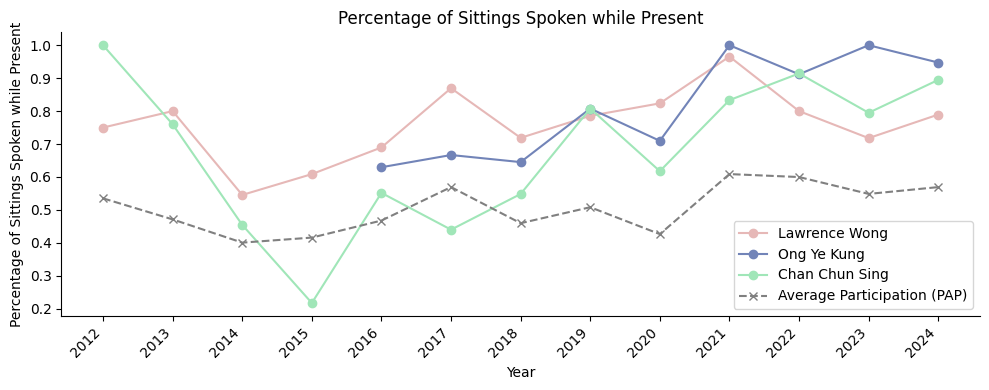

In [45]:
import numpy as np
import matplotlib.ticker as ticker

# Group the data by year and member name
summary_perc = percentage_sittings_spoken_of_present.groupby(['year', 'member_name'])['percentage_sittings_spoken_of_present'].sum().unstack().reset_index().set_index('year')
summary_perc = summary_perc.join(average_participation_pap.set_index('year'))

# Plotting
plt.figure(figsize=(10, 4))

# Create an array of indices for the x-axis
x = summary_perc.index

# Plot lines for each member
for member in members_to_analyse:
    plt.plot(x, summary_perc[member], marker='o', label=member, color=members_colors[member])

plt.plot(x, summary_perc['average_percentage_spoken'], marker='x', label='Average Participation (PAP)', color='gray', linestyle ='--')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Percentage of Sittings Spoken while Present')
plt.title('Percentage of Sittings Spoken while Present')
plt.xticks(list(x), rotation=45, ha='right', fontsize=10, fontname='DejaVu Sans')
plt.legend()

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove grid
plt.grid(False)

plt.tight_layout()
plt.show()

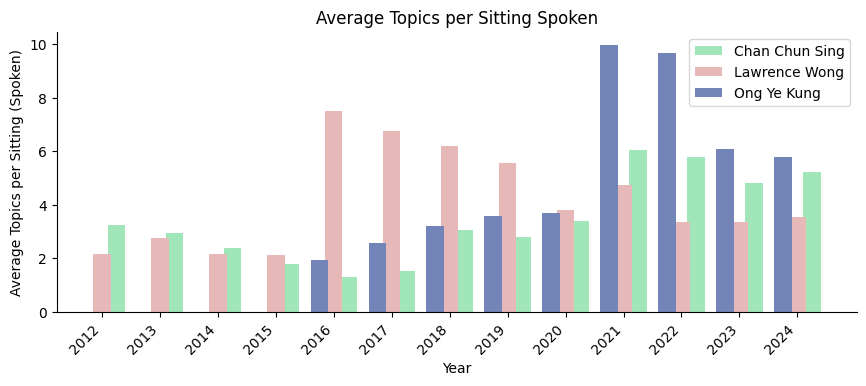

In [46]:
# Create subplots for bars and lines
fig, ax1 = plt.subplots(figsize=(10, 4))

width = 0.3
# Plot average_topics_per_sitting_spoken bars
init = -0.25
for member_name, member_data in summary.groupby('member_name'):
    x = member_data['year']  # Use 'year' data for x-axis
    y = member_data['average_topics_per_sitting_spoken']
    ax1.bar(x-init, y, width, label=member_name, color=members_colors[member_name])
    init += 0.25
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Topics per Sitting (Spoken)')
ax1.set_title('Average Topics per Sitting Spoken')
plt.xticks(range(summary['year'].min(), summary['year'].max() + 1), rotation=45, ha='right', fontsize=10, fontname='DejaVu Sans')
plt.yticks(fontsize=10, fontname='DejaVu Sans')
ax1.spines['top'].set_visible(False)  # Remove top spine
ax1.spines['right'].set_visible(False)  # Remove right spine
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend()

# Adjust layout to make room for all x-axis labels
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.9)

# Display the plot
plt.show()

## Speeches

* What are the number of words?
* What is the readability of his speeches?

How does this compare against the others?

The readability (Flesch reading ease) of the text is defined by:

$FRES = 206.835 - 1.015\left(\frac{\text{total words}}{\text{total sentences}}\right) - 84.6\left(\frac{\text{total syllables}}{\text{total words}}\right)$


In [47]:
query_speeches = f"""
select date, speech_id, topic_id, member_name, speech_text
from `singapore-parliament-speeches.prod_mart.mart_speeches`
where member_name in ({formatted_members})
"""

In [48]:
speeches_df = get_speech_df_from_query(query_speeches)

In [49]:
speeches_df['n_words'] = speeches_df['speech_text'].apply(calc_number_of_words)

In [50]:
speeches_df['n_sentences'] = speeches_df['speech_text'].apply(calc_number_of_sentences)

In [51]:
speeches_df['n_syllables'] = speeches_df['speech_text'].apply(calc_number_of_syllables)

In [52]:
speeches_df['year'] = pd.to_datetime(speeches_df['date']).dt.year

In [53]:
grouped_info = speeches_df.groupby(['year', 'member_name']).agg({
    'n_words': 'sum',
    'n_sentences': 'sum',
    'n_syllables': 'sum'
}).reset_index()

In [54]:
grouped_info.drop(['n_sentences', 'n_syllables'], axis=1).head(6)

,year,member_name,n_words
0,2012,Chan Chun Sing,11800
1,2012,Lawrence Wong,7429
2,2013,Chan Chun Sing,50512
3,2013,Lawrence Wong,44229
4,2014,Chan Chun Sing,23939
5,2014,Lawrence Wong,40620


In [55]:
grouped_info['fres'] = grouped_info.apply(calc_fres, axis=1)

In [56]:
grouped_info.drop(['n_words', 'n_sentences', 'n_syllables'], axis=1).head(6)

,year,member_name,fres
0,2012,Chan Chun Sing,32.599384
1,2012,Lawrence Wong,37.085956
2,2013,Chan Chun Sing,43.844848
3,2013,Lawrence Wong,37.291663
4,2014,Chan Chun Sing,42.753605
5,2014,Lawrence Wong,38.593164


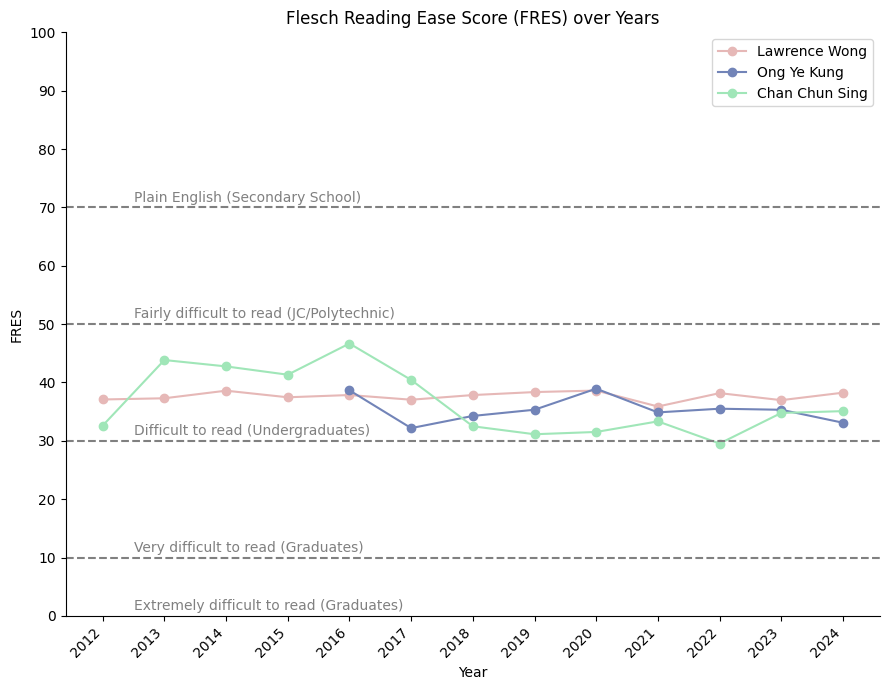

In [57]:
# Plotting
plt.figure(figsize=(9, 7))

# Separate data for each member
for member_name in members_to_analyse:
    data = grouped_info[grouped_info['member_name'] == member_name]
    plt.plot(data['year'], data['fres'], marker='o', label=member_name, color=members_colors[member_name])

plt.xlabel('Year')
plt.ylabel('FRES')
plt.title('Flesch Reading Ease Score (FRES) over Years')
plt.xticks(grouped_info['year'].unique(), rotation=45, ha='right', fontsize=10, fontname='DejaVu Sans')
plt.yticks(range(0, 101),fontsize=10, fontname='DejaVu Sans')
plt.legend()
plt.tight_layout()

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove grid
plt.grid(False)

# Show integer values on y-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Add reference lines
plt.axhline(y=10, color='gray', linestyle='--')
plt.axhline(y=30, color='gray', linestyle='--')
plt.axhline(y=50, color='gray', linestyle='--')
plt.axhline(y=70, color='gray', linestyle='--')

# Annotate the reference line
plt.text(grouped_info['year'].min() + 0.5, 0+1, 'Extremely difficult to read (Graduates)', color='gray', fontname='DejaVu Sans')
plt.text(grouped_info['year'].min() + 0.5, 10+1, 'Very difficult to read (Graduates)', color='gray', fontname='DejaVu Sans')
plt.text(grouped_info['year'].min() + 0.5, 30+1, 'Difficult to read (Undergraduates)', color='gray', fontname='DejaVu Sans')
plt.text(grouped_info['year'].min() + 0.5, 50+1, 'Fairly difficult to read (JC/Polytechnic)', color='gray', fontname='DejaVu Sans')
plt.text(grouped_info['year'].min() + 0.5, 70+1, 'Plain English (Secondary School)', color='gray', fontname='DejaVu Sans')

plt.show()

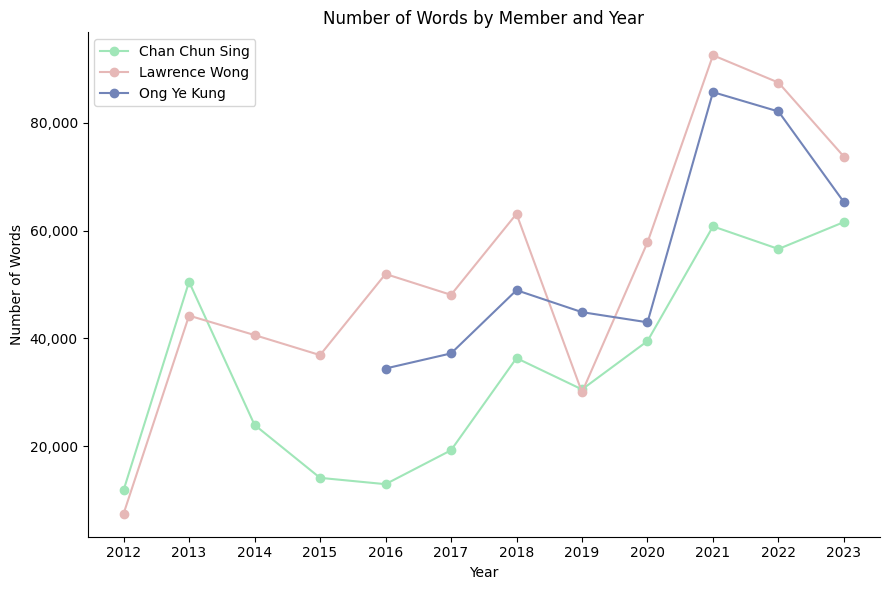

In [58]:
import numpy as np
import matplotlib.ticker as ticker

# Group the data by year and member name and sum the number of words (excluding 2024)
word_count_by_member = grouped_info[grouped_info['year']!=2024].groupby(['year', 'member_name'])['n_words'].sum().unstack()

# Plotting
plt.figure(figsize=(9, 6))

# Get the unique member names
members = grouped_info['member_name'].unique()

# Create an array of indices for the x-axis
x = word_count_by_member.index

# Plot lines for each member
for member in members:
    plt.plot(x, word_count_by_member[member], marker='o', label=member, color=members_colors[member])

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Words')
plt.title('Number of Words by Member and Year')
plt.xticks(x)  # Set x-ticks to unique years
plt.legend()

# Format y-axis ticks with commas
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove grid
plt.grid(False)

plt.tight_layout()
plt.show()